In [1]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Fetch Google (GOOGL) stock data from Yahoo Finance (2012-2016)
data = yf.download('GOOGL', start='2012-01-01', end='2016-12-31')

# Display the first few rows of data
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2012-01-03,16.572668,16.640911,16.247896,16.262092,146912940
2012-01-04,16.644150,16.693214,16.453370,16.563204,114445440
2012-01-05,16.413269,16.536803,16.344031,16.490977,131184684
2012-01-06,16.189367,16.437929,16.183638,16.416758,107608284
2012-01-09,15.502957,16.114149,15.472323,16.101696,232671096


In [3]:
# Use only the 'Open' price for prediction
open_prices = data[['Open']].values

# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
open_prices_scaled = scaler.fit_transform(open_prices)

# Prepare sequences (previous 60 days' data to predict the next day)
X_train = []
y_train = []

for i in range(60, len(open_prices_scaled)):
    X_train.append(open_prices_scaled[i-60:i, 0])  # Previous 60 days
    y_train.append(open_prices_scaled[i, 0])       # Predict next day

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for RNN input (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [4]:
# Build the RNN model
model = tf.keras.Sequential([
    layers.SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.SimpleRNN(50),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0746
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.5191e-04
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 9.5851e-04
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 7.1179e-04
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.3772e-04
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.6011e-04
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.2038e-04
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 7.4248e-04
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.4779e-04
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.3827e-04
Epoch 13/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.0461e-04
Epoch 14/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.4729e-04
Epoch 15/20
38/38 ━━━━━━━━━

In [6]:
# Fetch test data (last 2 years of stock data)
test_data = yf.download('GOOGL', start='2017-01-01', end='2017-12-31')
real_stock_price = test_data[['Open']].values

# Combine train and test data
total_data = pd.concat((data['Open'], test_data['Open']), axis=0)

# Prepare input for prediction
inputs = total_data[len(total_data) - len(test_data) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict stock prices
predicted_stock_price = model.predict(X_test)

# Reverse scaling to get actual stock price predictions
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)


[*********************100%***********************]  1 of 1 completed


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


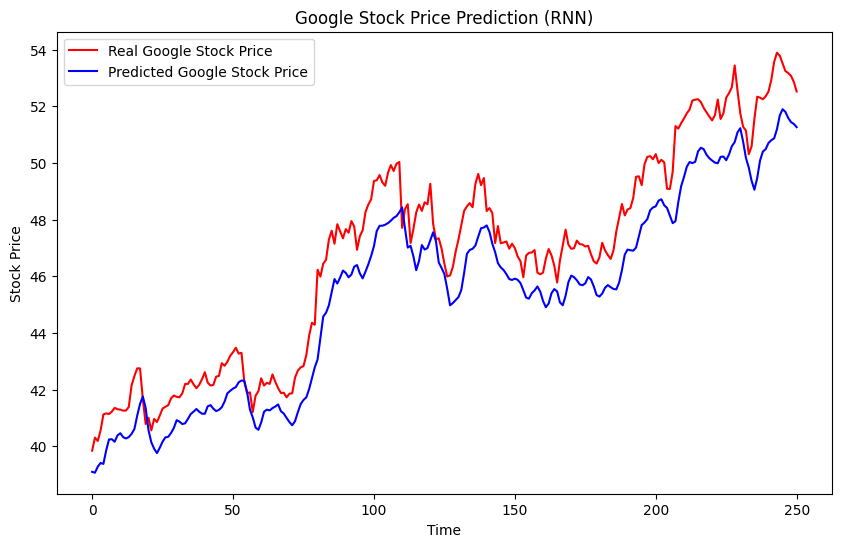

In [7]:
# Plot the real and predicted stock prices
plt.figure(figsize=(10,6))
plt.plot(real_stock_price, color='red', label='Real Google Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction (RNN)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
